In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plot
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet
from sklearn import metrics
from sklearn.model_selection import train_test_split,KFold
from sklearn.svm import SVR
#from sklearn. import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import RobustScaler

In [3]:
train_df = pd.read_csv('/Users/Navaneethan/Documents/Machine Learning/Kaggle/Elo/Data/train.csv')


In [4]:
test_df = pd.read_csv('/Users/Navaneethan/Documents/Machine Learning/Kaggle/Elo/Data/test.csv')

In [5]:
test_df.head()

,first_active_month,card_id,feature_1,feature_2,feature_3
0,2017-04,C_ID_0ab67a22ab,3,3,1
1,2017-01,C_ID_130fd0cbdd,2,3,0
2,2017-08,C_ID_b709037bc5,5,1,1
3,2017-12,C_ID_d27d835a9f,2,1,0
4,2015-12,C_ID_2b5e3df5c2,5,1,1


In [6]:
train_df.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [7]:
train_df.shape

(201917, 6)

In [8]:
train_df.describe()

,feature_1,feature_2,feature_3,target
count,201917.000000,201917.000000,201917.000000,201917.000000
mean,3.105311,1.745410,0.565569,-0.393636
std,1.186160,0.751362,0.495683,3.850500
min,1.000000,1.000000,0.000000,-33.219281
25%,2.000000,1.000000,0.000000,-0.883110
50%,3.000000,2.000000,1.000000,-0.023437
75%,4.000000,2.000000,1.000000,0.765453
max,5.000000,3.000000,1.000000,17.965068


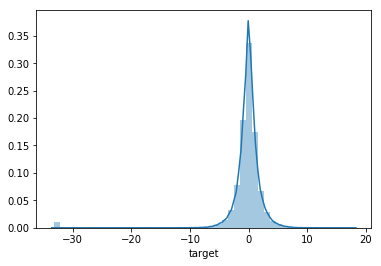

In [9]:
sns.distplot(train_df.target)

In [10]:
len(train_df.loc[train_df['target'] < -10])/len(train_df['target'])*100

1.1212527919887874

In [11]:
%%time
import dask.dataframe as dd
hist_df = dd.read_csv("/Users/Navaneethan/Documents/Machine Learning/Kaggle/Elo/Data/historical_transactions.csv").compute()



CPU times: user 2min 11s, sys: 37 s, total: 2min 48s
Wall time: 1min 52s


In [12]:
hist_df.dtypes

authorized_flag          object
card_id                  object
city_id                   int64
category_1               object
installments              int64
category_3               object
merchant_category_id      int64
merchant_id              object
month_lag                 int64
purchase_amount         float64
purchase_date            object
category_2              float64
state_id                  int64
subsector_id              int64
dtype: object

In [12]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [13]:
hist_new_df = hist_df.loc[hist_df['purchase_amount'] < 1]

reduce_mem_usage(hist_new_df, verbose=True)

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


Mem. usage decreased to 1892.82 Mb (42.5% reduction)


,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703125,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.732910,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720215,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722656,2017-03-10 01:14:19,1.0,16,37
5,Y,C_ID_4e6213e9bc,333,N,0,A,80,M_ID_50af771f8d,0,-0.734863,2018-02-24 08:45:05,1.0,9,37
6,Y,C_ID_4e6213e9bc,88,N,0,A,278,M_ID_5e8220e564,-11,-0.716797,2017-03-21 00:10:51,1.0,16,37
7,Y,C_ID_4e6213e9bc,3,N,0,A,80,M_ID_9d41786a50,-3,-0.657227,2017-11-18 20:05:55,1.0,16,37
8,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-8,-0.737793,2017-06-01 22:02:56,1.0,16,37
9,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_74ba14b5fc,-11,-0.715332,2017-03-16 15:41:22,1.0,16,37


In [16]:
train_df = pd.merge(train_df,hist_new_df , on="card_id", how="left")

In [17]:
%%time
reduce_mem_usage(train_df, verbose=True)


Mem. usage decreased to 1444.16 Mb (42.6% reduction)
CPU times: user 9.57 s, sys: 6.06 s, total: 15.6 s
Wall time: 10 s


,first_active_month,card_id,feature_1,feature_2,feature_3,target,authorized_flag,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,2017-06,C_ID_92a2005557,5,2,1,-0.820312,Y,69.0,N,0.0,A,195.0,M_ID_cc72dac895,-3.0,-0.505859,2017-11-25 16:37:11,1.0,9.0,34.0
1,2017-06,C_ID_92a2005557,5,2,1,-0.820312,Y,69.0,N,0.0,A,278.0,M_ID_c9c0f1cb3f,-7.0,-0.722168,2017-07-16 12:21:00,1.0,9.0,37.0
2,2017-06,C_ID_92a2005557,5,2,1,-0.820312,Y,69.0,N,0.0,A,683.0,M_ID_36f9e41993,-6.0,-0.726074,2017-08-10 21:01:16,1.0,9.0,34.0
3,2017-06,C_ID_92a2005557,5,2,1,-0.820312,Y,69.0,N,0.0,A,309.0,M_ID_b790230ee9,-2.0,-0.610352,2017-12-15 12:06:58,1.0,9.0,21.0
4,2017-06,C_ID_92a2005557,5,2,1,-0.820312,Y,69.0,N,0.0,A,278.0,M_ID_ab67f6c982,-7.0,-0.307129,2017-07-08 15:13:18,1.0,9.0,37.0
5,2017-06,C_ID_92a2005557,5,2,1,-0.820312,Y,69.0,N,0.0,A,560.0,M_ID_b3c49066d8,-6.0,-0.662109,2017-08-13 13:43:07,1.0,9.0,34.0
6,2017-06,C_ID_92a2005557,5,2,1,-0.820312,Y,69.0,N,0.0,A,560.0,M_ID_b3c49066d8,-1.0,-0.665527,2018-01-27 06:44:29,1.0,9.0,34.0
7,2017-06,C_ID_92a2005557,5,2,1,-0.820312,Y,69.0,N,0.0,A,560.0,M_ID_b3c49066d8,-7.0,-0.728027,2017-07-01 09:02:20,1.0,9.0,34.0
8,2017-06,C_ID_92a2005557,5,2,1,-0.820312,Y,69.0,N,0.0,A,80.0,M_ID_c124c4467a,-5.0,-0.621094,2017-09-02 23:05:56,1.0,9.0,37.0
9,2017-06,C_ID_92a2005557,5,2,1,-0.820312,Y,69.0,N,0.0,A,560.0,M_ID_1a81c358a3,-7.0,-0.722168,2017-07-27 08:17:48,1.0,9.0,34.0


In [18]:
test_df = pd.merge(test_df,hist_new_df , on="card_id", how="left")
reduce_mem_usage(test_df, verbose=True)

Mem. usage decreased to 866.69 Mb (40.7% reduction)


,first_active_month,card_id,feature_1,feature_2,feature_3,authorized_flag,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,2017-04,C_ID_0ab67a22ab,3,3,1,N,235.0,N,1.0,B,412.0,M_ID_85a5803161,-8.0,-0.697266,2017-04-27 14:17:27,1.0,12.0,18.0
1,2017-04,C_ID_0ab67a22ab,3,3,1,Y,235.0,N,1.0,B,278.0,M_ID_c873d839bd,-3.0,-0.716797,2017-09-21 22:11:57,1.0,12.0,37.0
2,2017-04,C_ID_0ab67a22ab,3,3,1,N,-1.0,Y,4.0,C,879.0,M_ID_9139332ccc,-6.0,-0.479980,2017-06-22 22:53:59,NaN,-1.0,29.0
3,2017-04,C_ID_0ab67a22ab,3,3,1,Y,235.0,N,1.0,B,80.0,M_ID_26c089d552,-8.0,-0.744141,2017-04-04 18:22:24,1.0,12.0,37.0
4,2017-04,C_ID_0ab67a22ab,3,3,1,Y,235.0,N,1.0,B,278.0,M_ID_26c089d552,-2.0,-0.711426,2017-10-06 23:51:21,1.0,12.0,37.0
5,2017-04,C_ID_0ab67a22ab,3,3,1,Y,79.0,N,1.0,B,307.0,M_ID_1473a4a533,0.0,-0.709473,2017-12-29 01:05:24,1.0,12.0,19.0
6,2017-04,C_ID_0ab67a22ab,3,3,1,Y,69.0,N,1.0,B,879.0,M_ID_00a6ca8a8a,-5.0,-0.721680,2017-07-04 11:52:51,1.0,9.0,29.0
7,2017-04,C_ID_0ab67a22ab,3,3,1,N,-1.0,Y,6.0,C,879.0,M_ID_9139332ccc,-6.0,-0.243530,2017-06-22 22:48:04,NaN,-1.0,29.0
8,2017-04,C_ID_0ab67a22ab,3,3,1,N,235.0,N,1.0,B,80.0,M_ID_26c089d552,-2.0,-0.691406,2017-10-07 05:34:29,1.0,12.0,37.0
9,2017-04,C_ID_0ab67a22ab,3,3,1,Y,235.0,N,1.0,B,298.0,M_ID_cfe5c1d77a,-6.0,-0.679199,2017-06-16 10:42:42,1.0,12.0,10.0


In [19]:
train_df['purchase_amount'] = train_df['purchase_amount'].fillna(0)

In [20]:
test_df['purchase_amount'] = test_df['purchase_amount'].fillna(0)

In [21]:
test_df.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,authorized_flag,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,2017-04,C_ID_0ab67a22ab,3,3,1,N,235.0,N,1.0,B,412.0,M_ID_85a5803161,-8.0,-0.697266,2017-04-27 14:17:27,1.0,12.0,18.0
1,2017-04,C_ID_0ab67a22ab,3,3,1,Y,235.0,N,1.0,B,278.0,M_ID_c873d839bd,-3.0,-0.716797,2017-09-21 22:11:57,1.0,12.0,37.0
2,2017-04,C_ID_0ab67a22ab,3,3,1,N,-1.0,Y,4.0,C,879.0,M_ID_9139332ccc,-6.0,-0.479980,2017-06-22 22:53:59,NaN,-1.0,29.0
3,2017-04,C_ID_0ab67a22ab,3,3,1,Y,235.0,N,1.0,B,80.0,M_ID_26c089d552,-8.0,-0.744141,2017-04-04 18:22:24,1.0,12.0,37.0
4,2017-04,C_ID_0ab67a22ab,3,3,1,Y,235.0,N,1.0,B,278.0,M_ID_26c089d552,-2.0,-0.711426,2017-10-06 23:51:21,1.0,12.0,37.0


In [71]:
x = pd.DataFrame(train_df[['purchase_amount','feature_1','feature_2']])
y = pd.DataFrame(train_df['target'])
model = Lasso()
kfold = KFold(n_splits=2,shuffle=True,random_state=42)
for i,(train,test) in enumerate(kfold.split(x,y)):
    model.fit(x.iloc[train],y.iloc[train])
    score = model.score(x.iloc[test],y.iloc[test])
    Predict_test_linear = model.predict(x.iloc[test])
    scores.append(score)
print(scores)
print('Average score:',np.average(scores))
print('MSE for test data:',np.sqrt(metrics.mean_squared_error(y.iloc[test], Predict_test_linear)))
print(Predict_test_linear)

/Applications/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


[0.0007576267868362186, 0.0007198391869117637, 1.0, 1.0, -0.0008383415345742939, -0.0006309900978402894, 1.0, 1.0, 0.0007576267868362186, 0.0007198391869117637, 0.0007576267868362186, 0.0007198391869117637]
Average score: 0.33358025552406917
MSE for test data: 3.618143295259844
[-0.44671499 -0.44671499 -0.44671499 ... -0.44671499 -0.44671499
 -0.44671499]


In [69]:
np.unique(x)

array([-0.747 , -0.7466, -0.746 , ...,  0.999 ,  0.9995,  1.    ],
      dtype=float16)

In [72]:
round(np.var(hist_df['purchase_amount']),10)

1262300.850847045

In [52]:
train_df[['purchase_amount','target']].describe()

,purchase_amount,target
count,1.781538e+07,1.781538e+07
mean,NaN,NaN
std,0.000000e+00,0.000000e+00
min,-7.470703e-01,-3.321875e+01
25%,-7.207031e-01,-7.939453e-01
50%,-6.899414e-01,-8.013916e-02
75%,-6.108398e-01,5.532227e-01
max,1.000000e+00,1.796875e+01


In [51]:
x = pd.DataFrame(train_df['purchase_amount'])
y = pd.DataFrame(train_df['target'])
rbX = RobustScaler()
x = rbX.fit_transform(x)
rbY = RobustScaler()
y = rbY.fit_transform(y)
X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.3, random_state=42)
model_lr = Lasso()
model_lr.fit(X_train, y_train)
Lasso_test_score = model_lr.score(X_test, y_test)
Predict_test_Lasso = model_lr.predict(rbX.transform(X_test))
Predict_test_Lasso = rbY.inverse_transform(Predict_test_Lasso)
#svm_pred = svm.predict(rbX.transform(predict))
print("Lasso regression test score:", Lasso_test_score)
print(Predict_test_Lasso)

/Applications/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


ValueError: Expected 2D array, got 1D array instead:
array=[-0.27136016 -0.27136016 -0.27136016 ... -0.27136016 -0.27136016
 -0.27136016].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [43]:
X = pd.DataFrame(train_df['purchase_amount'])
y = pd.DataFrame(train_df['target'])

X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.3, random_state=42)
model_lr = Lasso()
model_lr.fit(X_train, y_train)
coeff_used = np.sum(model_lr.coef_!=0)

Lasso_train_score = model_lr.score(X_train,y_train)
Lasso_test_score = model_lr.score(X_test, y_test)
Predict_test_Lasso = model_lr.predict(X_test)

print("Lasso regression train score:", Lasso_train_score)
print("Lasso regression test score:", Lasso_test_score)
print("number of features used: ", coeff_used)
print('RSquare value(test):',np.round(model_lr.score(X_test, y_test)*100,2))
print('MSE for test data:',np.round(metrics.mean_squared_error(y_test, Predict_test_Lasso),2))

TypeError: 'bool' object is not callable

In [31]:
X_test

,purchase_amount
11474780,-0.641602
1422208,-0.673340
1000630,-0.738281
2337640,-0.740234
7213780,-0.701660
13282497,-0.587402
14525655,-0.612305
17655574,-0.671875
4206468,-0.524414
8186860,-0.551758


In [ ]:
x = pd.DataFrame(test_df['purchase_amount'])
#y = pd.DataFrame(test_df['target'])
#model = Lasso()
scores = []
#kfold = KFold(n_splits=2,shuffle=True,random_state=42)
#for i,(train,test) in enumerate(kfold.split(x,y)):
#model.fit(x.iloc[train],y.iloc[train])
#score = model.score(x.iloc[test],y.iloc[test])
output = model.predict(x)
#scores.append(score)
#print(scores)
#print('Average score:',np.average(scores))
#print('MSE for test data:',np.sqrt(metrics.mean_squared_error(test_df.target, Predict_test_linear)))


In [ ]:
X = pd.DataFrame(medicine_df[['R','Slope','Force','Pressure']])
y = pd.DataFrame(medicine_df['StrengthIn'])

X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.3, random_state=4)
model_lr = Lasso()
model_lr.fit(X_train, y_train)
coeff_used = np.sum(model_lr.coef_!=0)

Lasso_train_score = model_lr.score(X_train,y_train)
Lasso_test_score = model_lr.score(X_test, y_test)
Predict_test_Lasso = model_lr.predict(X_test)

print("Lasso regression train score:", Lasso_train_score)
print("Lasso regression test score:", Lasso_test_score)
print("number of features used: ", coeff_used)
print('RSquare value(test):',np.round(model_lr.score(X_test, y_test)*100,2))
print('MSE for test data:',np.round(metrics.mean_squared_error(y_test, Predict_test_Lasso),2))

In [ ]:
sub_df = pd.DataFrame({"card_id":test_df["card_id"].values})
#sub_df["target"] = output
#sub_df.to_csv("output.csv", index=False)

In [ ]:
 ! kaggle competitions submit -c elo-merchant-category-recommendation -f output.csv -m "Try1"

In [39]:
predict = pd.DataFrame(test_df['purchase_amount'])
model.predict(predict)

/Applications/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


array([-0.44671499, -0.44671499, -0.44671499, ..., -0.44671499,
       -0.44671499, -0.44671499])

In [42]:
np.unique(Predict_test_Lasso)

array([-0.44570687])